In [1]:
# Utilities
import os
import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Data
from sklearn.datasets import make_moons, make_circles, make_blobs

# Models
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier, NearestNeighbors
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from imblearn.over_sampling import SMOTE, ADASYN, BorderlineSMOTE, RandomOverSampler
from ctgan import CTGAN

from moms_generate import transform  
from moms_losses import MMD_est_torch
from moms_metrics import Metrics
from moms_visualize import visualize_samples

In [2]:
def generate_datasets(n_samples, noise, imbalance_ratio, dataset_type="moons", random_state=1203):
    if dataset_type == "moons":
        data, labels = make_moons(n_samples=n_samples, noise=noise, random_state=random_state)
    elif dataset_type == "circles":
        data, labels = make_circles(n_samples=n_samples, noise=0.2, factor=0.6, random_state=random_state)
    elif dataset_type == "blobs":
        centers = [(0, 0), (2, 1)]  # Majority and minority centers
        cluster_std = [1.0, 1.0]
        data, labels = make_blobs(n_samples=n_samples, centers=centers, cluster_std=cluster_std, random_state=random_state)
    else:
        raise ValueError("Invalid dataset type. Choose from 'moons', 'circles', or 'blobs'.")
    
    # Determine number of majority and minority samples.
    n_major = round(n_samples * imbalance_ratio / (1 + imbalance_ratio))
    n_minor = n_samples - n_major

    X_maj = data[labels == 0][:n_major]
    X_min = data[labels == 1][:n_minor]

    return X_maj, X_min, data, labels

Using device: cuda
Using device: cuda
Generating moons dataset...


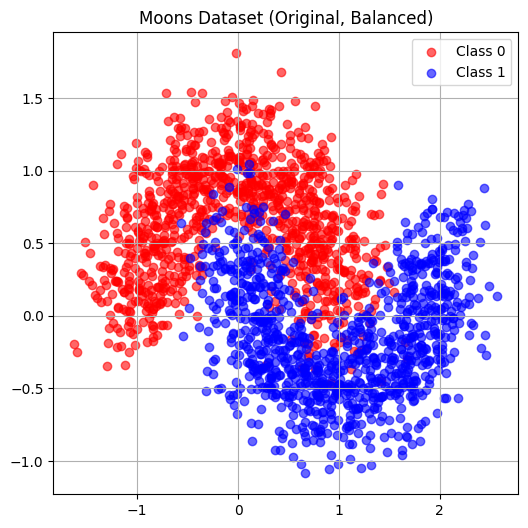

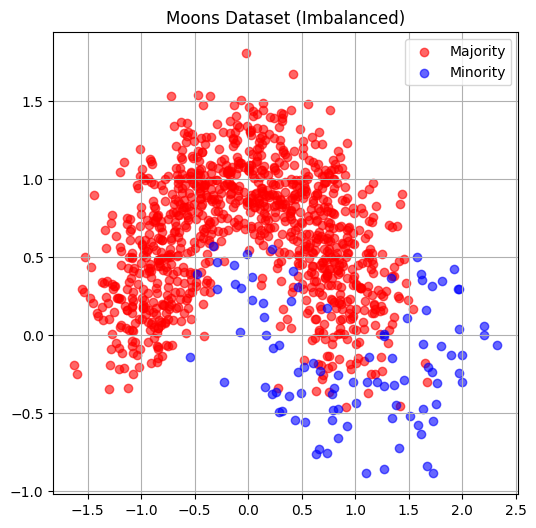

In [3]:
# hyperparameters
os.environ["CUDA_VISIBLE_DEVICES"] = "6"
device = "cuda"
print(f"Using device: {device}")
n_runs = 5        # number of experimental runs
n_train = 2000    # training sample size
n_test = 100      # test sample size
eps = 0.25         # noise level for dataset generation
input_dim = 2     # data dimension (e.g., 2 for moons/circles)
imb_ratio = 20
print(f"Using device: {device}")
n_epochs = 500   # epochs for transformation training
lr = 0.001
bw = 1.0

# Example of dataset generation
for dataset_type in ["moons"]:
# for dataset_type in ["moons"]:
    print(f"Generating {dataset_type} dataset...")
    X_maj, X_min, data, labels = generate_datasets(
        n_samples=n_train,
        noise=eps,
        imbalance_ratio=imb_ratio,
        dataset_type=dataset_type,
        random_state=1203
    )
    
    # Visualization of the original balanced dataset
    plt.figure(figsize=(6, 6))
    plt.scatter(data[labels == 0][:, 0], data[labels == 0][:, 1], color='red', alpha=0.6, label="Class 0")
    plt.scatter(data[labels == 1][:, 0], data[labels == 1][:, 1], color='blue', alpha=0.6, label="Class 1")
    plt.title(f"{dataset_type.capitalize()} Dataset (Original, Balanced)")
    plt.legend()
    plt.grid(True)
    plt.show()
    
    # Visualization of the imbalanced dataset
    plt.figure(figsize=(6, 6))
    plt.scatter(X_maj[:, 0], X_maj[:, 1], color='red', alpha=0.6, label="Majority")
    plt.scatter(X_min[:, 0], X_min[:, 1], color='blue', alpha=0.6, label="Minority")
    plt.title(f"{dataset_type.capitalize()} Dataset (Imbalanced)")
    plt.legend()
    plt.grid(True)
    plt.show()

In [4]:
# -------------------------------
# Define classification models
# -------------------------------
rf = RandomForestClassifier(n_estimators=100, max_depth=10, random_state=1203)
knn = KNeighborsClassifier(n_neighbors=5)
log_reg = LogisticRegression(max_iter=1000, random_state=1203)
svm = SVC(kernel="rbf", probability=True, random_state=1203)

models = {
    "Random Forest": rf,
    "KNN": knn,
    "Logistic Regression": log_reg,
    "SVM": svm,
}

dataset_types = ["moons"]
methods = ["Original", "SMOTE", "ADASYN", "Borderline-SMOTE", "Random Oversampling", "Trans(Direct)", "Trans(Noise)", "CTGAN"]

# Define test imbalance ratios
# te_imb_ratios = [1, 10, imb_ratio, 50]  
te_imb_ratios = [imb_ratio]  

In [5]:
k = 5

# Combine samples and find neighbors
X_all = np.vstack([X_min, X_maj])
nn = NearestNeighbors(n_neighbors=k+1).fit(X_all)
_, nn_idx = nn.kneighbors(X_min)

In [6]:
danger_mask = [
    i for i, indices in enumerate(nn_idx[:, 1:]) 
    if np.sum(indices >= len(X_min)) > k//2
]

In [7]:
dists = np.linalg.norm(X_maj[:, None] - X_min, axis=2)
border_indices = np.argpartition(dists.min(1), 100)[:100]
border_set = X_maj[border_indices]

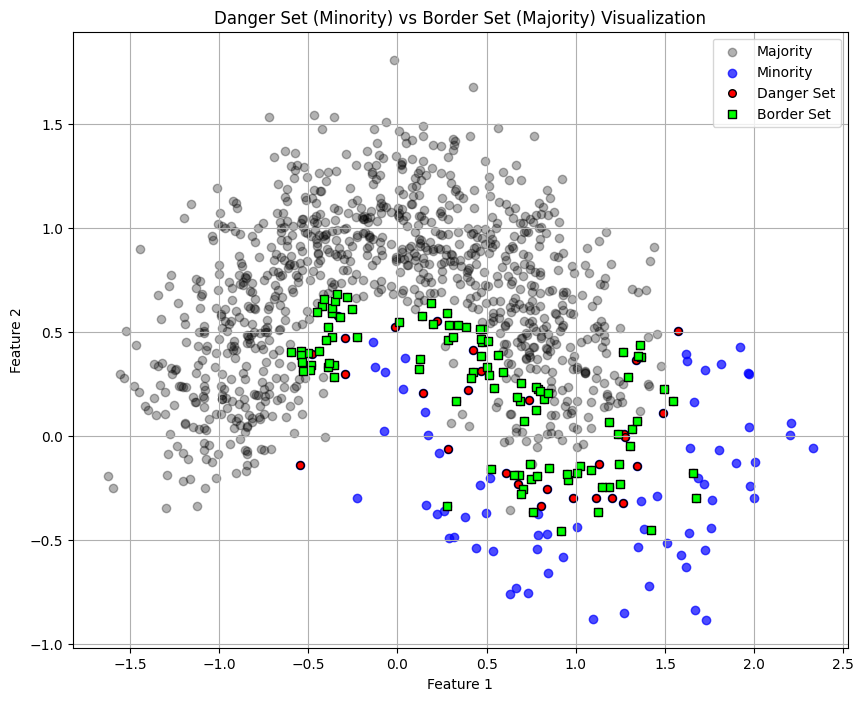

In [8]:
plt.figure(figsize=(10, 8))
plt.scatter(X_maj[:,0], X_maj[:,1], c='black', alpha=0.3, label='Majority')
plt.scatter(X_min[:,0], X_min[:,1], c='blue', alpha=0.7, label='Minority')
plt.scatter(X_min[danger_mask,0], X_min[danger_mask,1], 
            c='red', s=30, edgecolor='black', label='Danger Set')
plt.scatter(border_set[:,0], border_set[:,1], 
            c='lime', s=30, marker='s', edgecolor='black', label='Border Set')

plt.title('Danger Set (Minority) vs Border Set (Majority) Visualization')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.legend()
plt.grid(True)
plt.show()

Processing dataset type: moons
Processing experiments with test imbalance ratio: 20
Run 1/5 - Generating moons dataset...


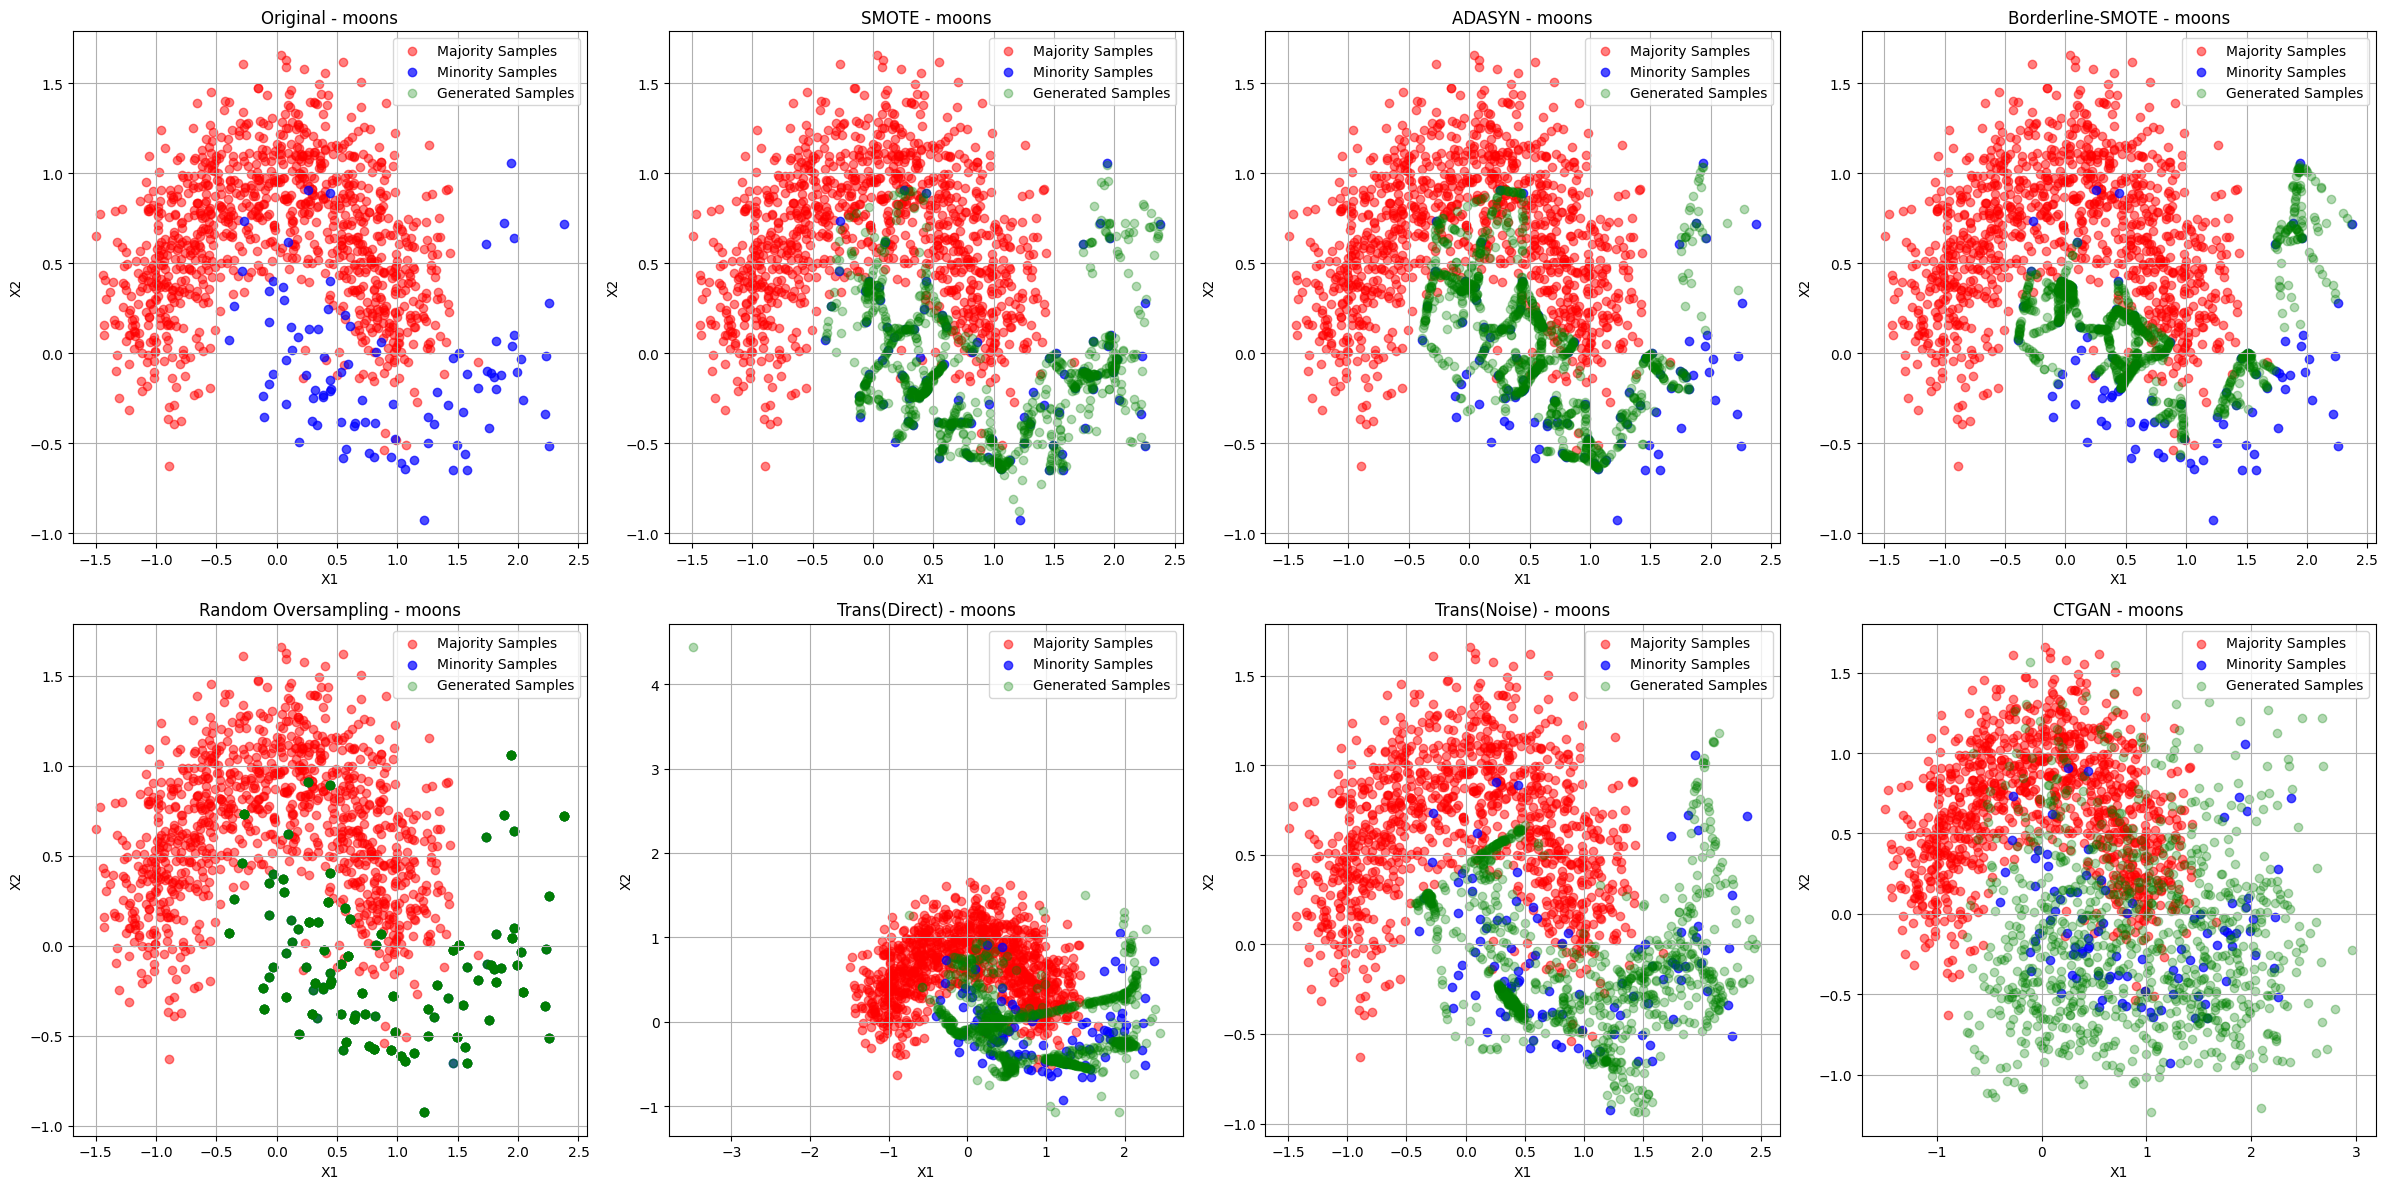

Run 2/5 - Generating moons dataset...


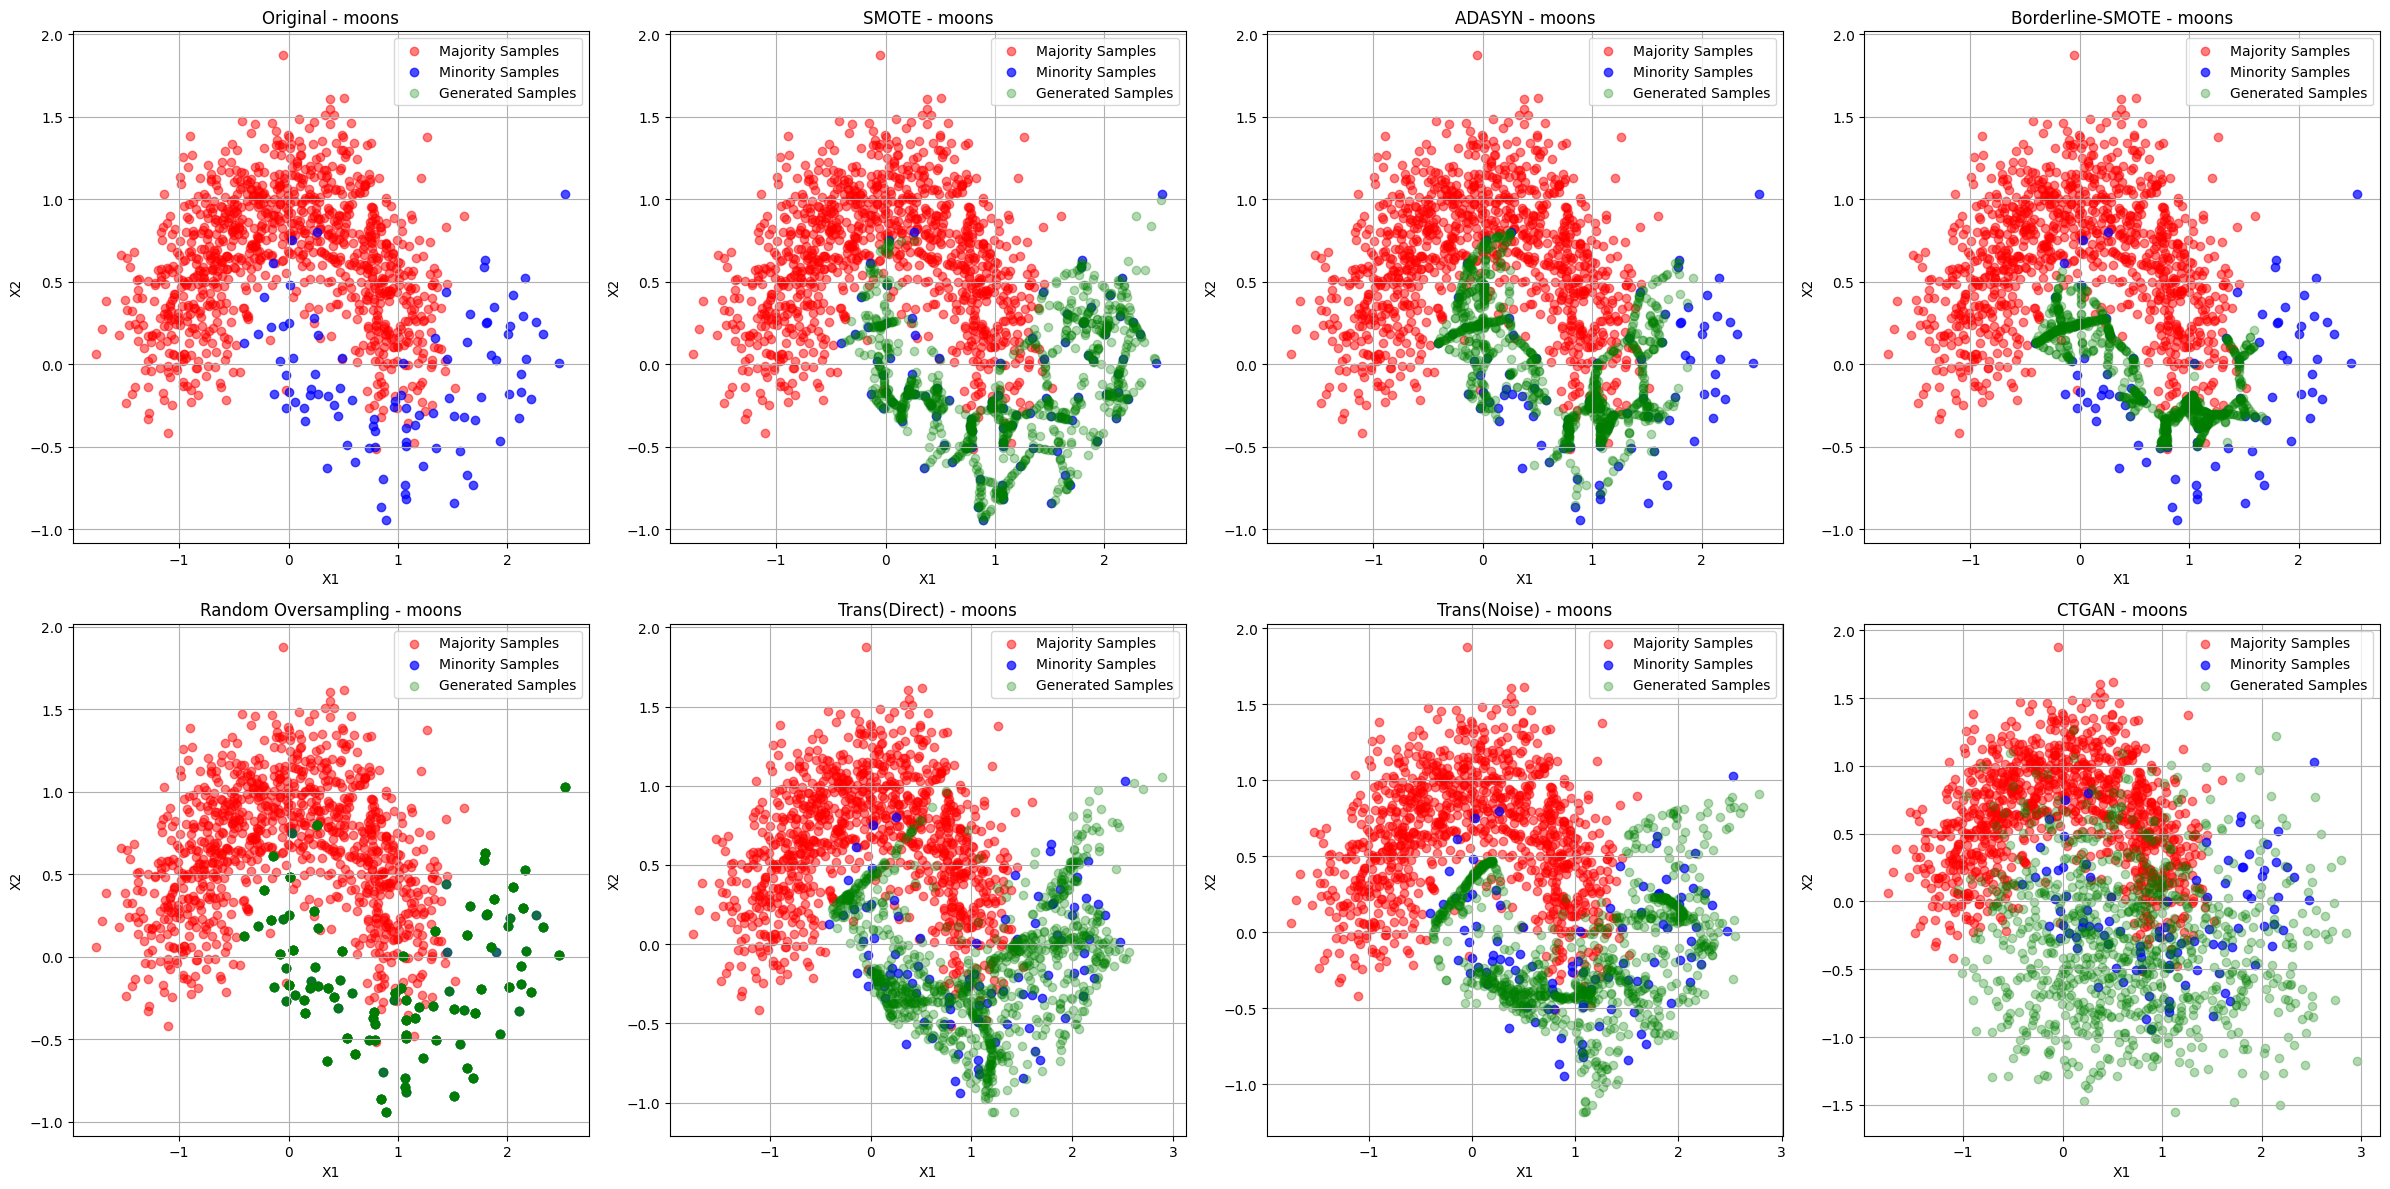

Run 3/5 - Generating moons dataset...


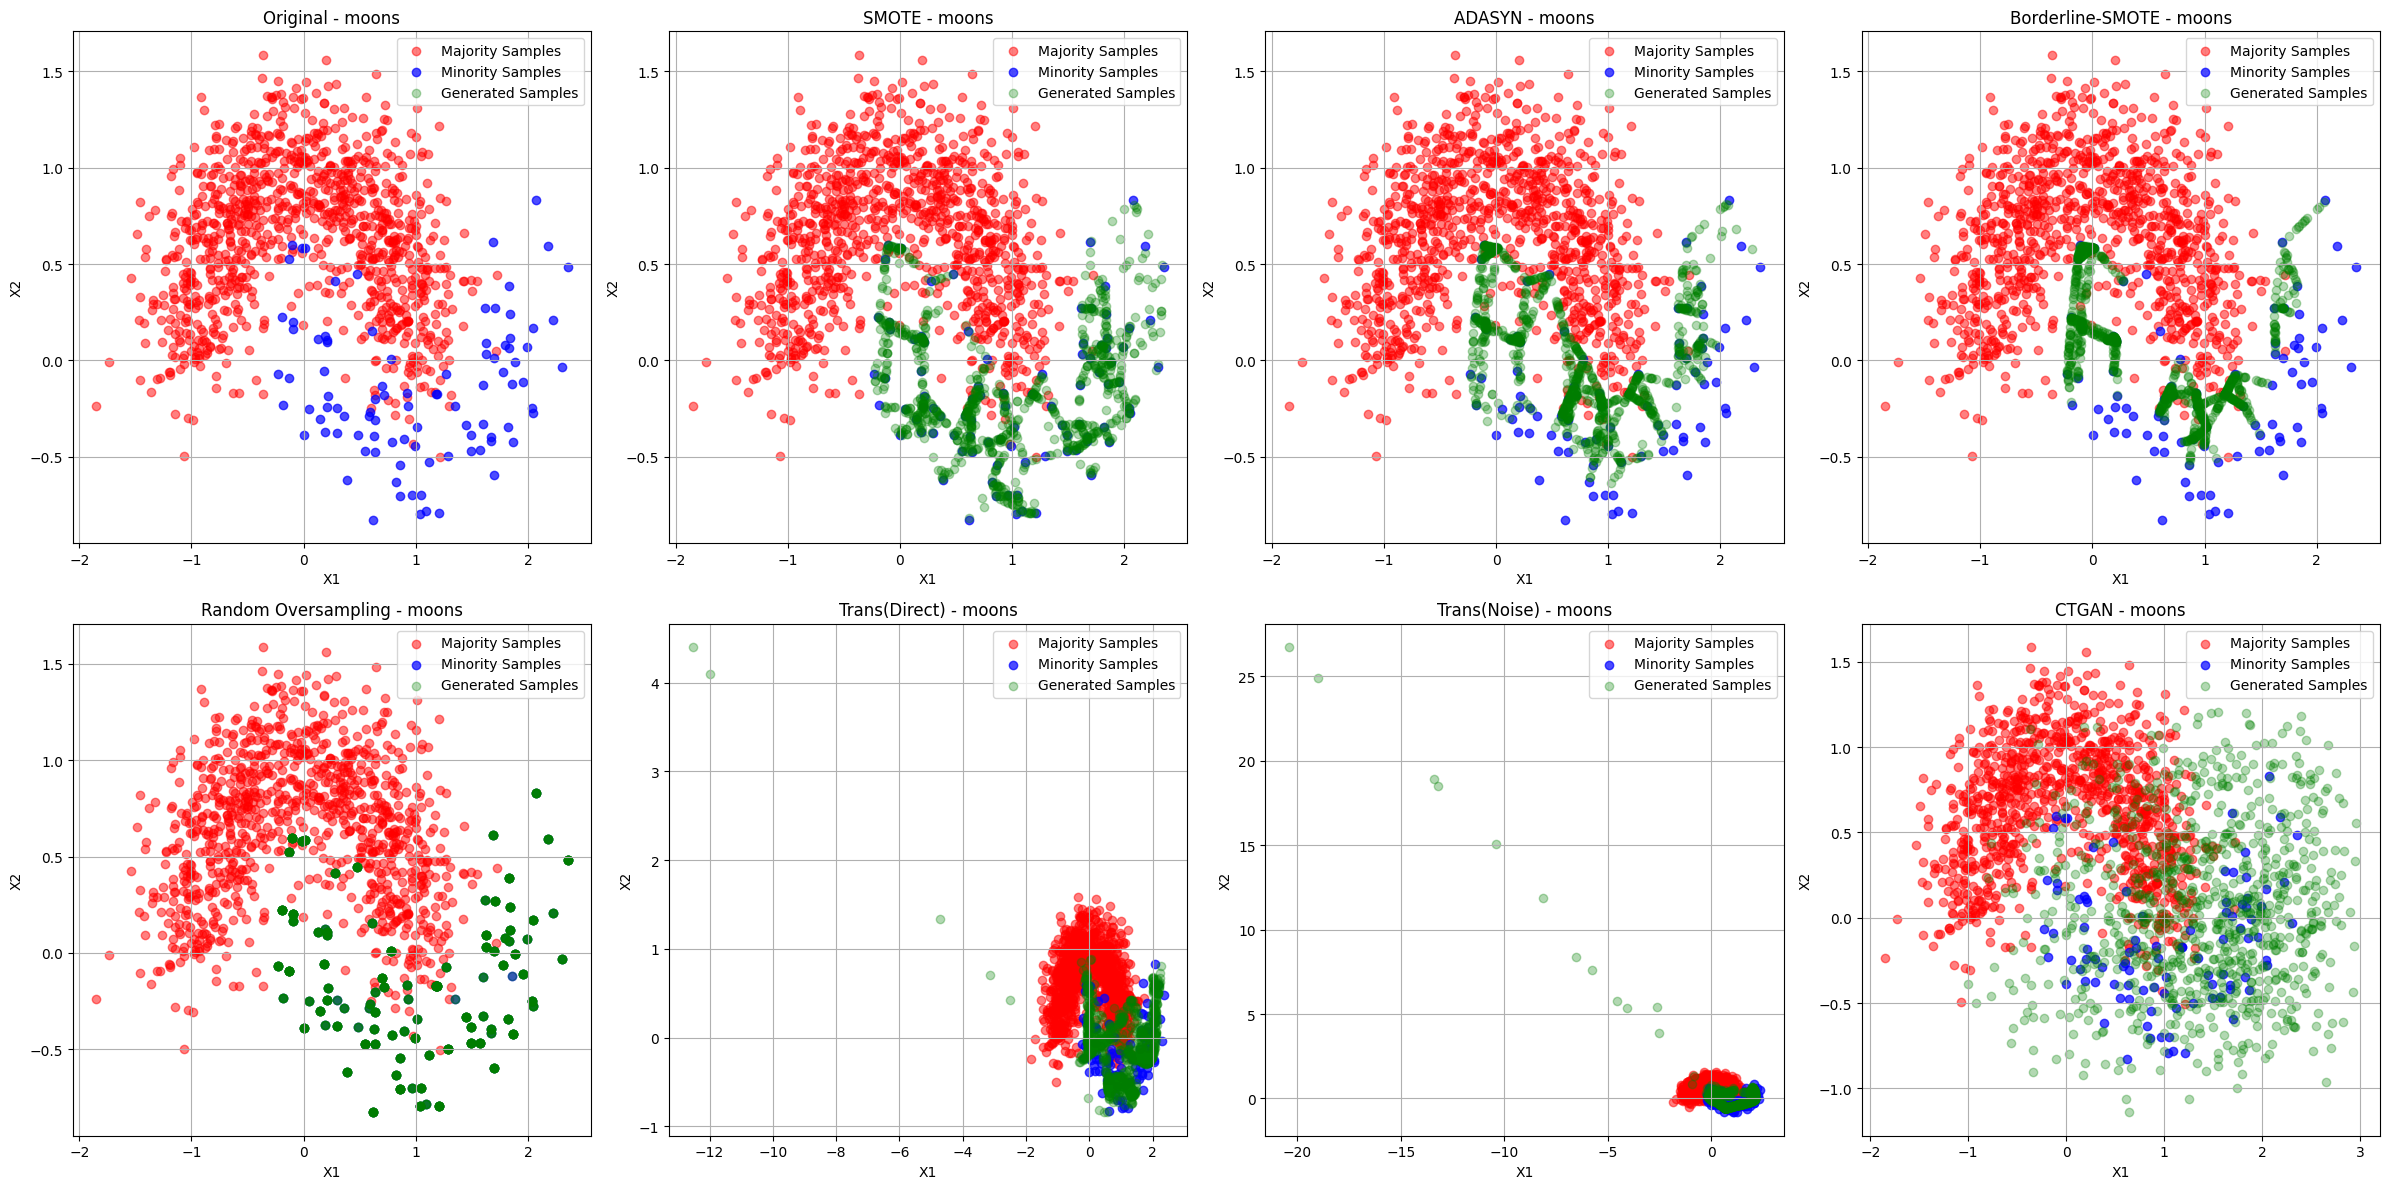

Run 4/5 - Generating moons dataset...


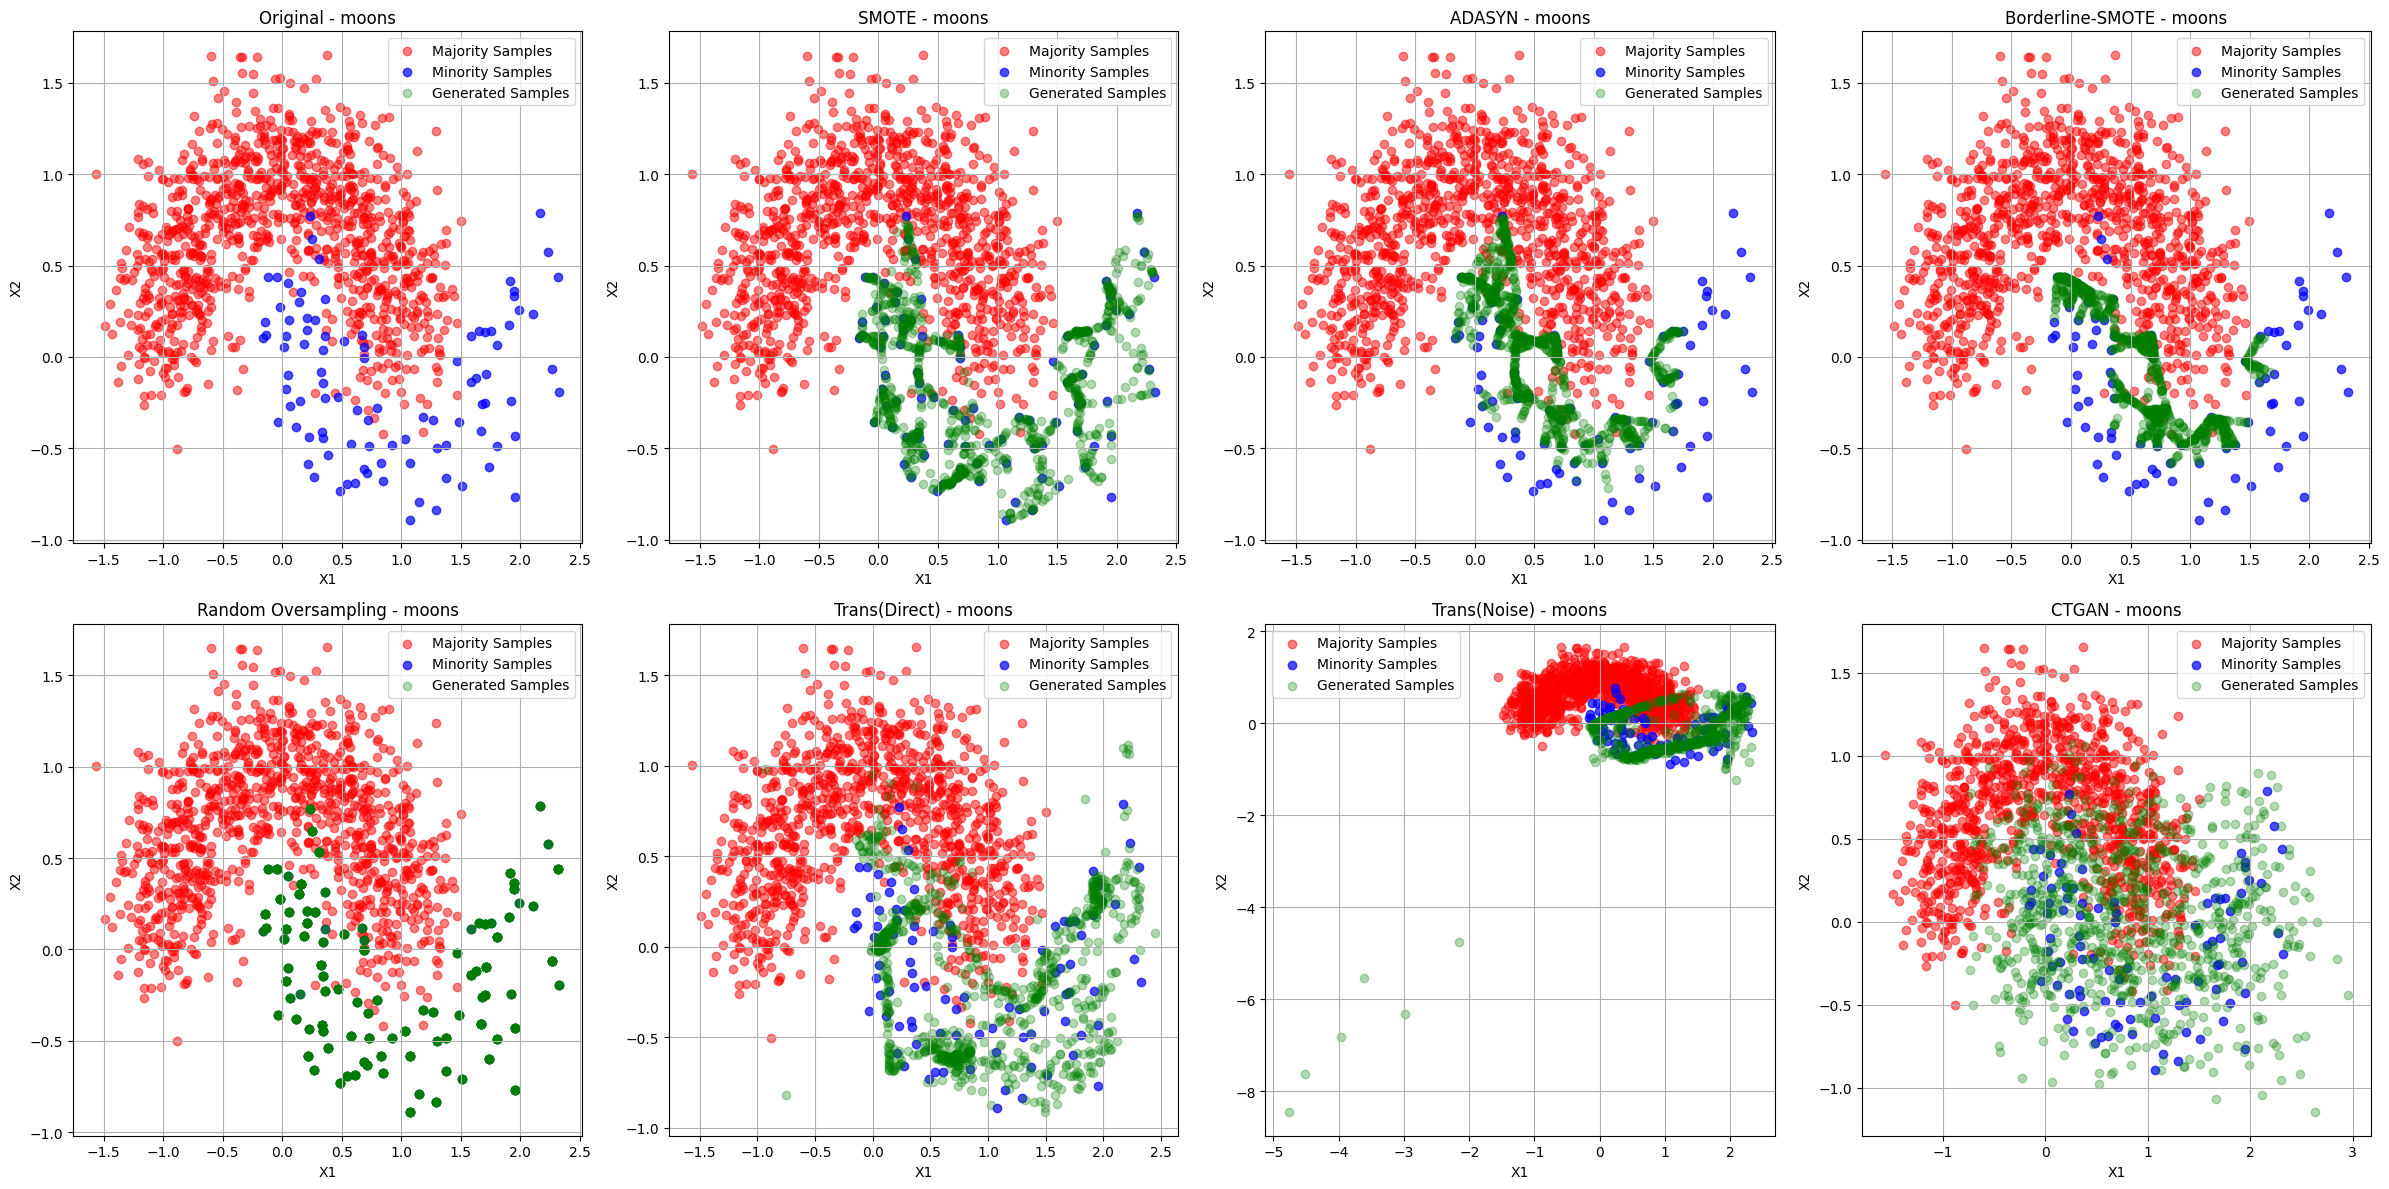

Run 5/5 - Generating moons dataset...


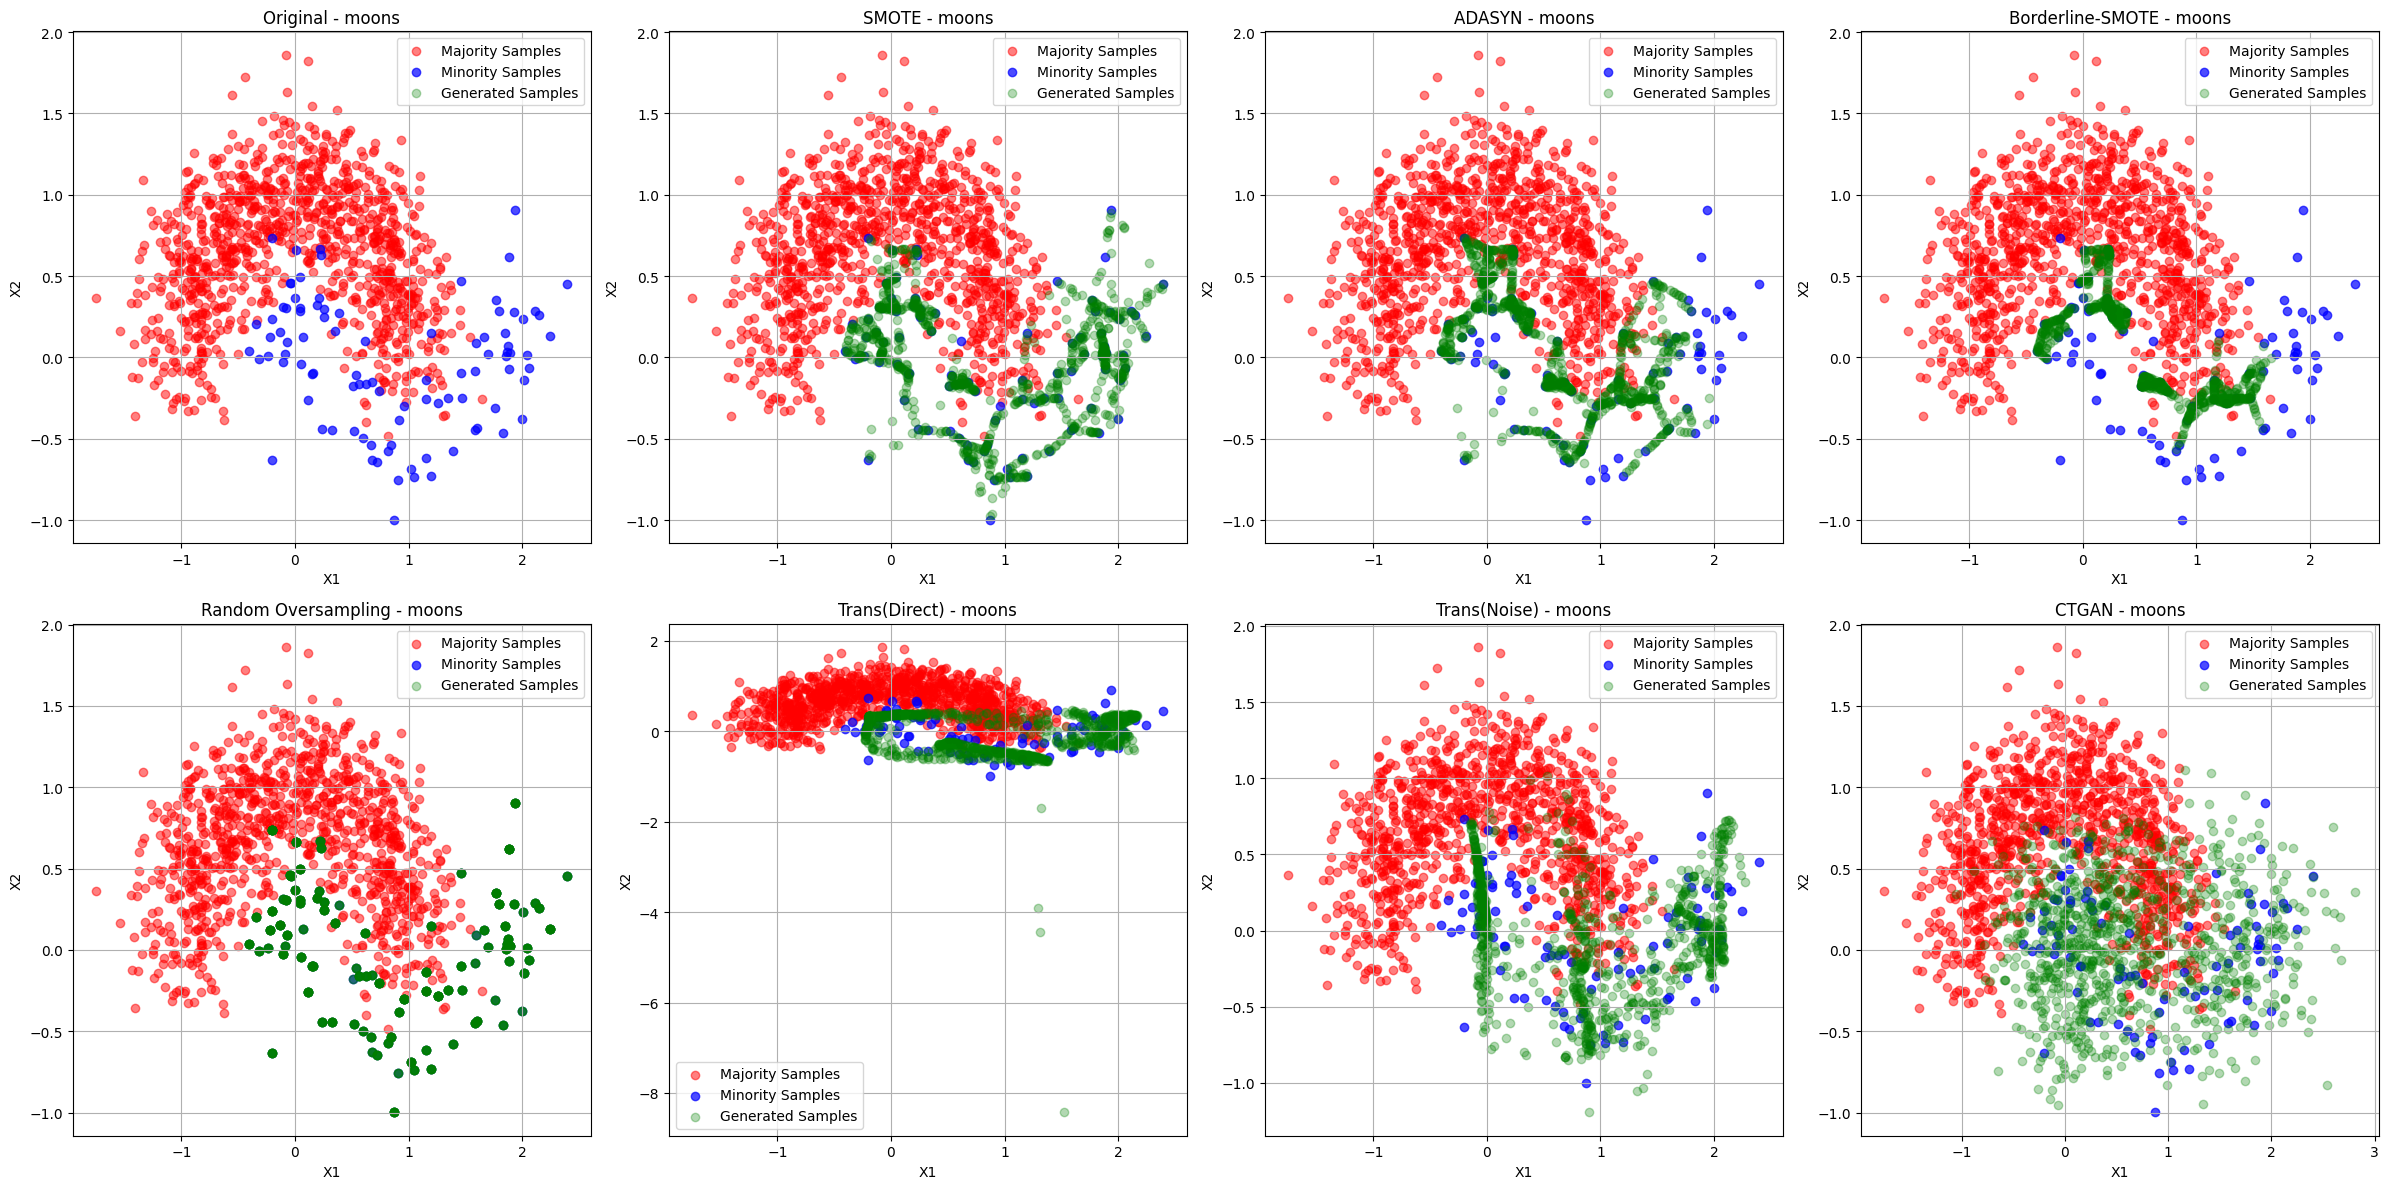

OSError: Cannot save file into a non-existent directory: 'results/sim_results'

In [9]:
for dataset_type in dataset_types:
    print(f"Processing dataset type: {dataset_type}")
    
    results = {
        method: {model_name: {"G-mean": [], "F1-score": [], "MCC": [], "Accuracy": [], "AUROC": []} for model_name in models.keys()}
        for method in methods
    }
    for te_imb_ratio in te_imb_ratios:
        print(f"Processing experiments with test imbalance ratio: {te_imb_ratio}")

        for run in range(n_runs):
            print(f"Run {run + 1}/{n_runs} - Generating {dataset_type} dataset...")
            seed = 1203 * te_imb_ratio + run
            # Generate training data
            X_tr_maj, X_tr_min, _, _ = generate_datasets(
                n_samples=n_train,
                noise=eps,
                imbalance_ratio=imb_ratio,
                dataset_type=dataset_type,
                random_state=seed
            )
            n_maj = len(X_tr_maj)
            n_min = len(X_tr_min)
            X_tr = np.vstack((X_tr_maj, X_tr_min))
            tr_labels = np.hstack((np.ones(n_maj), np.zeros(n_min)))

            # Generate test data with the specified imbalance ratio
            X_te_maj, X_te_min, _, _ = generate_datasets(
                n_samples=n_test,
                noise=eps,
                imbalance_ratio=te_imb_ratio,
                dataset_type=dataset_type,
                random_state=seed + n_test
            )
            X_te = np.vstack((X_te_maj, X_te_min))
            te_labels = np.hstack((np.ones(len(X_te_maj)), np.zeros(len(X_te_min))))
 
            # Apply transformations
            X_tr_maj_direct, X_tr_min_direct, X_tr_trans_direct = transform(
                X_tr_maj,
                X_tr_min,
                in_dim=input_dim,
                latent_dim=64,
                hidden_dims=[4, 8, 16, 32],  
                loss_fn=MMD_est_torch,
                device=device,
                method='direct',
                median_bw=False,
                n_epochs=1000,
                beta=0.0,
                lr=0.001,
                seed=seed,
                residual=True
            )

            X_tr_maj_noise, X_tr_min_noise, X_tr_trans_noise = transform(
                X_tr_maj,
                X_tr_min,
                in_dim=input_dim,
                latent_dim=64,  
                hidden_dims=[4, 8, 16, 32], 
                loss_fn=MMD_est_torch,
                kernel_type='gaussian',
                median_bw=False, 
                device=device,
                method="noise",
                n_epochs=1000,
                beta=0.0,
                lr=0.001,
                seed=seed,
                residual=True
            )
            
            # CTGAN
            ctgan = CTGAN(epochs=n_epochs)
            ctgan.fit(X_tr_min)
            X_tr_min_ctgan = ctgan.sample(n_maj - n_min)
            datasets = {
                "Original": (X_tr, tr_labels),
                "SMOTE": SMOTE(random_state=seed).fit_resample(X_tr, tr_labels),
                "ADASYN": ADASYN(random_state=seed).fit_resample(X_tr, tr_labels),
                "Borderline-SMOTE": BorderlineSMOTE(random_state=seed).fit_resample(X_tr, tr_labels),
                "Random Oversampling": RandomOverSampler(random_state=seed).fit_resample(X_tr, tr_labels),
                "Trans(Direct)": (np.vstack((X_tr_maj_direct, X_tr_min_direct, X_tr_trans_direct)),
                                    np.hstack((np.ones(len(X_tr_maj_direct)), np.zeros(len(X_tr_min_direct)), np.zeros(len(X_tr_trans_direct))))),
                "Trans(Noise)": (np.vstack((X_tr_maj_noise, X_tr_min_noise, X_tr_trans_noise)),
                                    np.hstack((np.ones(len(X_tr_maj_noise)), np.zeros(len(X_tr_min_noise)), np.zeros(len(X_tr_trans_noise))))),
                "CTGAN": (np.vstack((X_tr_maj, X_tr_min, X_tr_min_ctgan)),
                          np.hstack((np.ones(len(X_tr_maj)), np.zeros(len(X_tr_min) + len(X_tr_min_ctgan)))))
            }   
            # Evaluate each model and method
            for method, (X_train, y_train) in datasets.items():
                for model_name, model in models.items():
                    model.fit(X_train, y_train)
                    
                    y_pred = model.predict(X_te)
                    y_pred_prob = model.predict_proba(X_te)[:, 1] if hasattr(model, "predict_proba") else None

                    # Calculate metrics
                    metrics = Metrics(te_labels, y_pred, y_pred_prob)
                    results[method][model_name]["G-mean"].append(metrics.g_mean())
                    results[method][model_name]["F1-score"].append(metrics.f1_score())
                    results[method][model_name]["MCC"].append(metrics.mcc())
                    results[method][model_name]["Accuracy"].append(metrics.accuracy())
                    if y_pred_prob is not None:
                        results[method][model_name]["AUROC"].append(metrics.roc_auc())

            if run >= 0:
                # Visualize results
                fig, axes = plt.subplots(2, 4, figsize=(24, 12))
                axes = axes.ravel()  # Flatten the 3x2 grid to a 1D array for easier iteration

                for i, (method, (X_method, _)) in enumerate(datasets.items()):
                    if i >= len(axes):  # Skip if there are more datasets than subplots
                        break
                    ax = axes[i]
                    if method == "Trans(Direct)":
                        generated_samples = X_method[len(X_tr_maj_direct) + len(X_tr_min_direct):]
                        visualize_samples(ax, X_tr_maj_direct, X_tr_min_direct, generated_samples, f"{method} - {dataset_type}")
                    elif method == "Trans(Noise)":
                        generated_samples_noise = X_method[len(X_tr_maj_noise) + len(X_tr_min_noise):]
                        visualize_samples(ax, X_tr_maj_direct, X_tr_min_noise, generated_samples_noise, f"{method} - {dataset_type}")
                    else:
                        generated_samples = X_method[len(X_tr):]
                        visualize_samples(ax, X_tr_maj, X_tr_min, generated_samples, f"{method} - {dataset_type}")

                # Adjust layout and display the plot
                plt.tight_layout()
                plt.show()
                    
        # Summarize results
        result_summary = {}
        for method, method_results in results.items():
            summary = {}
            for model_name, metrics in method_results.items():
                for metric_name, values in metrics.items():
                    # Compute the average metric across runs
                    avg_value = np.round(np.mean(values), 4) if values else "Not available"
                    summary[f"{model_name}_{metric_name}"] = avg_value
            result_summary[method] = summary

        # Convert result_summary to a DataFrame
        df = pd.DataFrame.from_dict(result_summary, orient="index")

        # Save to CSV
        output_path = f"results/sim_results/{dataset_type}_te_imb_{te_imb_ratio}_results.csv"
        df.to_csv(output_path, index=True)
        print(f"Results saved to {output_path}")